## Set Up

In [2]:
import torch
import os
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device

Torch: 2.5.1+cu121
CUDA available: True


device(type='cuda')

In [6]:
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "dataset/1/HMU-GC-HE-30K/all_image")
data_dir = os.path.abspath(data_dir) 

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), #turns image into numpy array
    transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
])

loaded_data = datasets.ImageFolder(root = data_dir, transform = transform)

train_size = int(0.8 * len(loaded_data))
val_train = len(loaded_data)-train_size
half_train = int(0.5*val_train)

train_dataset, temp_dataset = random_split(loaded_data, [train_size, val_train])
val_dataset, test_dataset = random_split(temp_dataset, [half_train,half_train])

len(train_dataset), len(val_dataset), len(test_dataset)


(24876, 3110, 3110)

Corrupted images: []
Total corrupted: 0


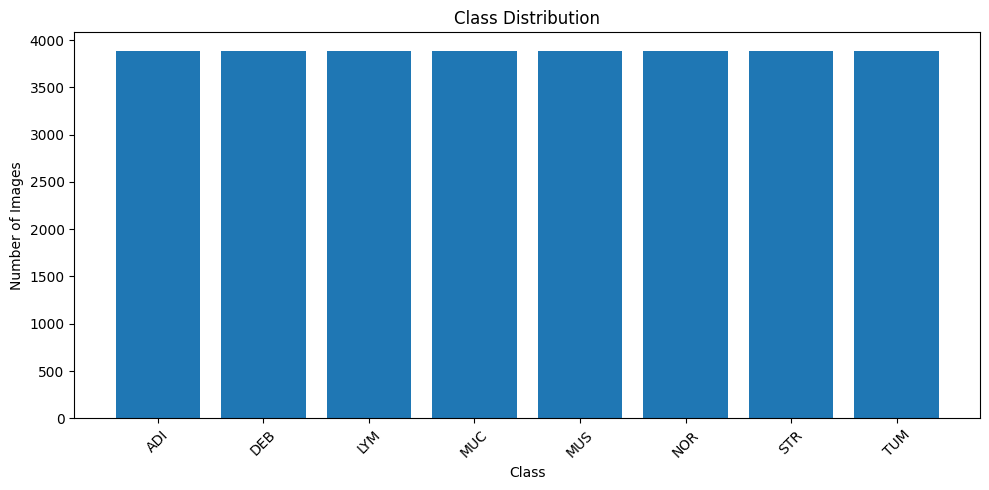

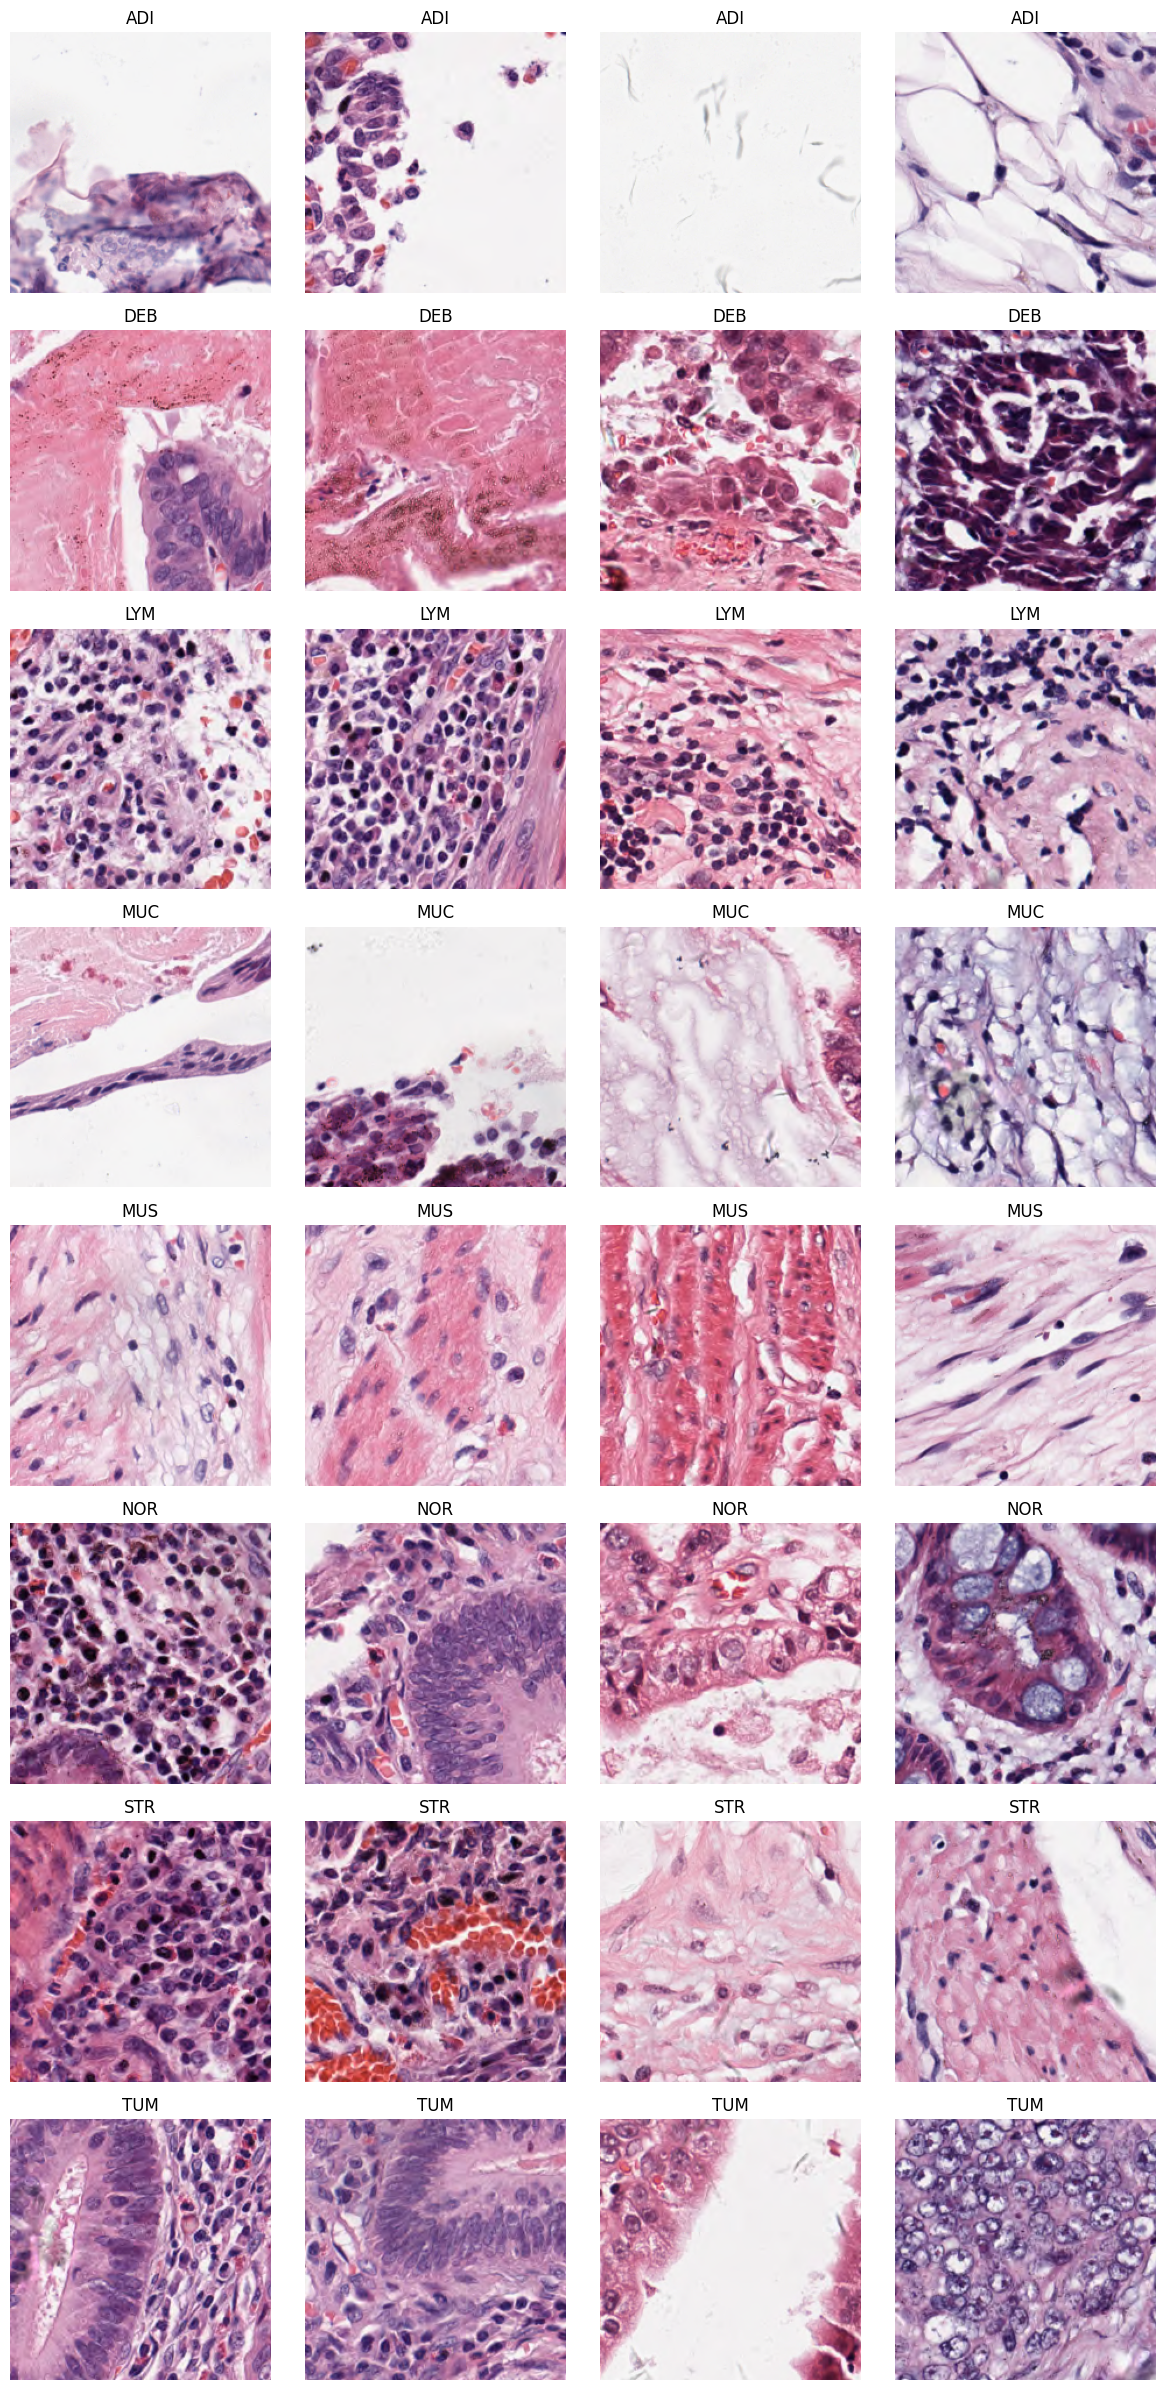

In [7]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_counts = defaultdict(int)
for img_path, label in dataset.samples:
    class_counts[label] += 1

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

labels = [idx_to_class[i] for i in class_counts.keys()]
counts = [class_counts[i] for i in class_counts.keys()]


corrupted = []

for img_path, _ in dataset.samples:
    try:
        img = Image.open(img_path)
        img.verify()  # load header only
    except Exception:
        corrupted.append(img_path)

print("Corrupted images:", corrupted)
print("Total corrupted:", len(corrupted))


plt.figure(figsize=(10,5))
plt.bar(labels, counts)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


def show_grid(dataset, idx_to_class, samples_per_class=4):
    classes = list(idx_to_class.values())
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(12, 3*num_classes))

    for cls_idx, cls_name in enumerate(classes):
        imgs = [s[0] for s in dataset.samples if s[1] == cls_idx][:samples_per_class]
        
        for j, path in enumerate(imgs):
            img = Image.open(path).convert("RGB")
            axs[cls_idx, j].imshow(img)
            axs[cls_idx, j].set_title(cls_name)
            axs[cls_idx, j].axis("off")

    plt.tight_layout()
    plt.show()

show_grid(dataset, idx_to_class)

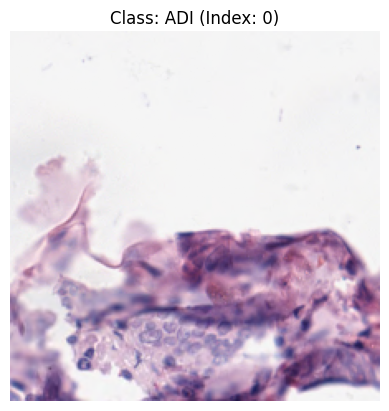

torch.Size([3, 224, 224])


In [8]:
image_tensor, label_index = loaded_data[0]
image_np = image_tensor.permute(1,2,0).numpy() # C, H, W -> H, W, C
image_np = (image_np+1)/2
class_name = loaded_data.classes[0]
plt.imshow(image_np)
plt.title(f"Class: {class_name} (Index: {0})")
plt.axis('off')
plt.show()
print(image_tensor.shape)

In [9]:
train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = 128)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = 32)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = 32)
len(train_loader), len(val_loader), len(test_loader)


(195, 98, 98)

In [10]:
import torch
import torch.nn as nn

class H_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes = 8):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 12, kernel_size = 3) ##224-2 = 222/2 = 111
        self.relu1 = nn.ReLU()
        self.maxP1 = nn.MaxPool2d(2) #takes the max and discards the rest

        self.conv2 = nn.Conv2d(12, 24, kernel_size = 3) ## 111-2 = 109/2= 54
        self.relu2 = nn.ReLU()
        self.maxP2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(24, 64, kernel_size = 3) ## 54 - 2 = 52 / 2 = 26
        self.relu3 = nn.ReLU()
        self.maxP3 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(43264, num_classes)

    def forward(self, x): #receives X, put through convolution first, self.conv1(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxP1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxP2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxP3(x)
        x = self.flatten(x)
        out = self.linear(x)
        return out
        

In [11]:
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    # (preds == targets) → boolean tensor showing which predictions are correct
    # .float() → convert True/False to 1.0/0.0
    # .mean() → average across the batch = fraction correct
    # .item() → convert scalar tensor to regular Python float
    return (preds == targets).float().mean().item()
    
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(logits.detach(), y)
        n_batches += 1
    return total_loss/n_batches, total_acc/n_batches
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            total_acc += accuracy(logits, y)
            n_batches += 1
    return total_loss/n_batches,total_acc/n_batches

def metrics(model, history, test_loader):
    epochs = history['epoch']

    # ---- Loss Curves ----
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=history["train_loss"], marker="o", label="Train Loss")
    sns.lineplot(x=epochs, y=history["val_loss"], marker="o", label="Val Loss")
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # ---- Accuracy Curves ----
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=history["train_acc"], marker="o", label="Train Acc")
    sns.lineplot(x=epochs, y=history["val_acc"], marker="o", label="Val Acc")
    plt.title('Training and Validation Accuracy Curves')   # FIXED
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')                                 # FIXED
    plt.grid(True)
    plt.show()

    # ---- Evaluation ----
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu()

            y_pred.extend(preds.tolist())
            y_true.extend(y.tolist())

    # ---- Confusion Matrix ----
    cf_matrix = confusion_matrix(y_true, y_pred)
    f1_cnn = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {f1_cnn:.4f}")

    plt.figure(figsize=(6,4))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [12]:
import pandas as pd
model = H_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 

EPOCHS = 10
results = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
    vl, va = evaluate(model, test_loader, criterion)

    results.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(model.state_dict(), 'Final_Project_Weights')

# Convert to DataFrame for analysis
history_cnn = pd.DataFrame(results)

Epoch 01 | train_loss=1.6159 val_loss=1.5015 train_acc=0.3610 val_acc=0.4003
Epoch 02 | train_loss=1.4162 val_loss=1.4411 train_acc=0.4470 val_acc=0.4328
Epoch 03 | train_loss=1.3517 val_loss=1.3854 train_acc=0.4760 val_acc=0.4548
Epoch 04 | train_loss=1.3157 val_loss=1.3775 train_acc=0.4921 val_acc=0.4602
Epoch 05 | train_loss=1.2820 val_loss=1.3428 train_acc=0.5083 val_acc=0.4759
Epoch 06 | train_loss=1.2573 val_loss=1.3342 train_acc=0.5201 val_acc=0.4842
Epoch 07 | train_loss=1.2315 val_loss=1.3348 train_acc=0.5341 val_acc=0.4858
Epoch 08 | train_loss=1.2084 val_loss=1.3464 train_acc=0.5418 val_acc=0.4848
Epoch 09 | train_loss=1.1877 val_loss=1.3321 train_acc=0.5534 val_acc=0.4950
Epoch 10 | train_loss=1.1571 val_loss=1.3247 train_acc=0.5666 val_acc=0.4947


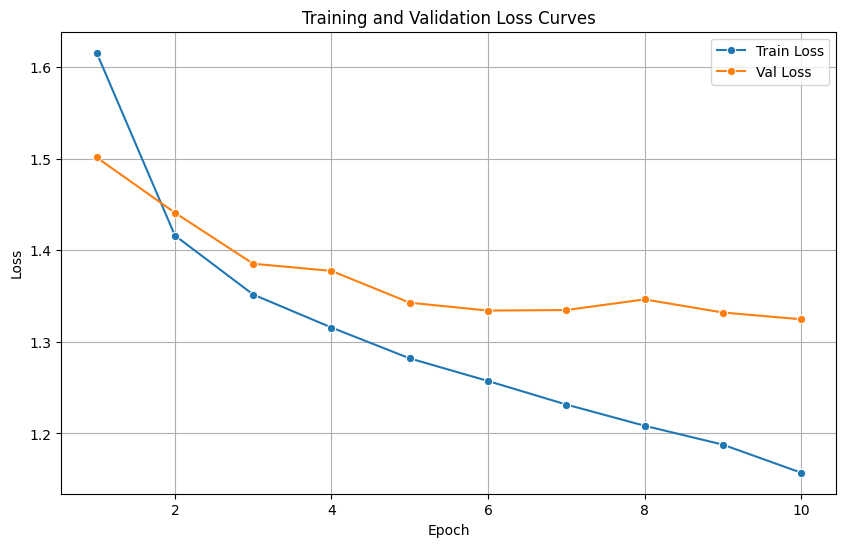

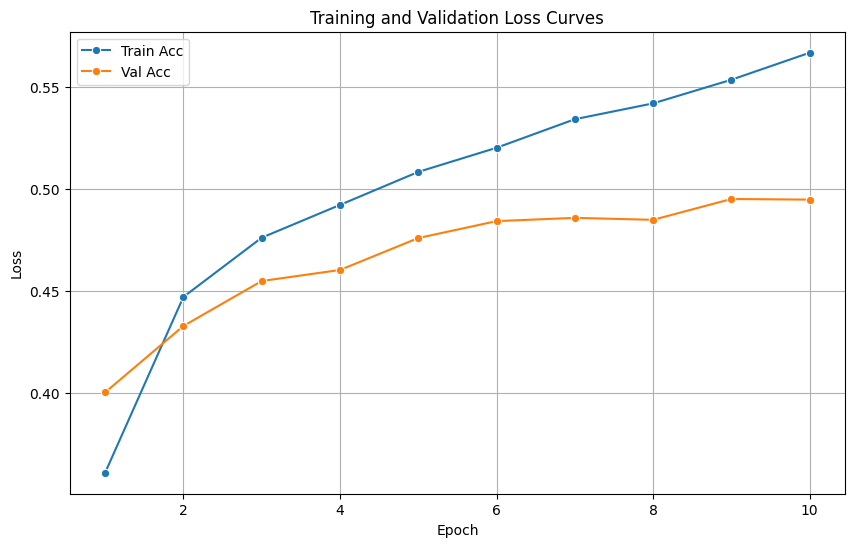

F1 Score (CNN, macro): 0.4582


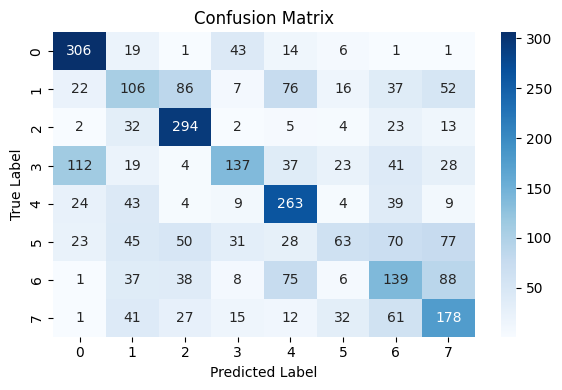

In [15]:
model = H_CNN()
model.load_state_dict(torch.load(os.path.join(parent_dir,'model','Final_Project_Weights')))

metrics(model, history_cnn, test_loader)



In [17]:
class ResNet_pre(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        # freeze backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        
        # replace fc with a trainable classifier
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
modelRS = ResNet_pre().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRS.parameters(), lr=0.0001) 
EPOCHS = 10
resultsRS = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(modelRS, train_loader, optimizer, criterion)
    vl, va = evaluate(modelRS, test_loader, criterion)

    resultsRS.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(modelRS.state_dict(), 'RS_Final_Project_Weights')

# Convert to DataFrame for analysis
history_RS_cnn = pd.DataFrame(resultsRS)

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | train_loss=1.8645 val_loss=1.6479 train_acc=0.3029 val_acc=0.4284
Epoch 02 | train_loss=1.5289 val_loss=1.4342 train_acc=0.4771 val_acc=0.4901
Epoch 03 | train_loss=1.3704 val_loss=1.3316 train_acc=0.5266 val_acc=0.5185
Epoch 04 | train_loss=1.2831 val_loss=1.2664 train_acc=0.5476 val_acc=0.5341
Epoch 05 | train_loss=1.2273 val_loss=1.2252 train_acc=0.5611 val_acc=0.5466
Epoch 06 | train_loss=1.1903 val_loss=1.1951 train_acc=0.5670 val_acc=0.5526
Epoch 07 | train_loss=1.1614 val_loss=1.1720 train_acc=0.5774 val_acc=0.5560
Epoch 08 | train_loss=1.1402 val_loss=1.1538 train_acc=0.5831 val_acc=0.5598
Epoch 09 | train_loss=1.1235 val_loss=1.1419 train_acc=0.5845 val_acc=0.5649
Epoch 10 | train_loss=1.1086 val_loss=1.1287 train_acc=0.5884 val_acc=0.5643


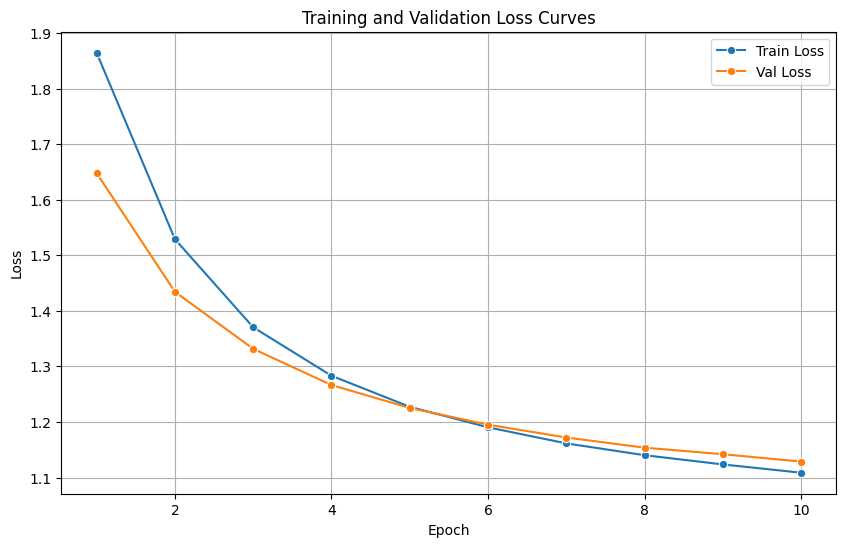

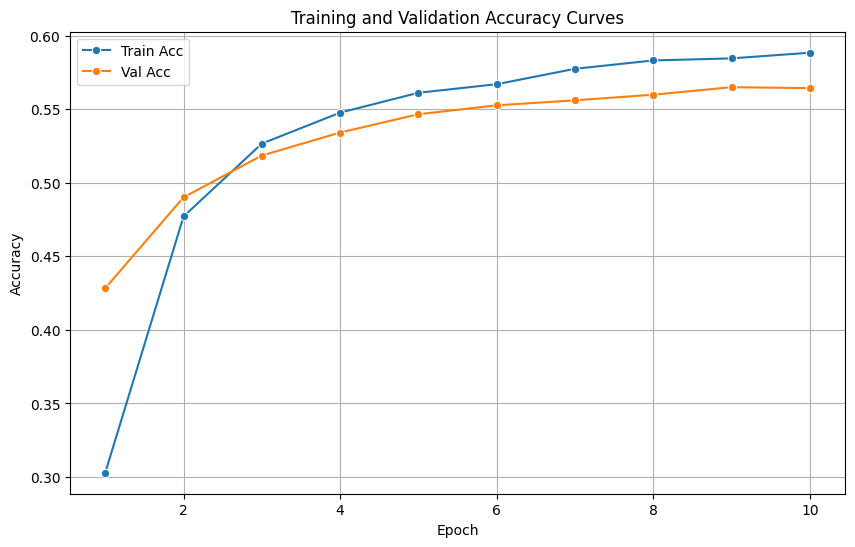

F1 Score: 0.6046


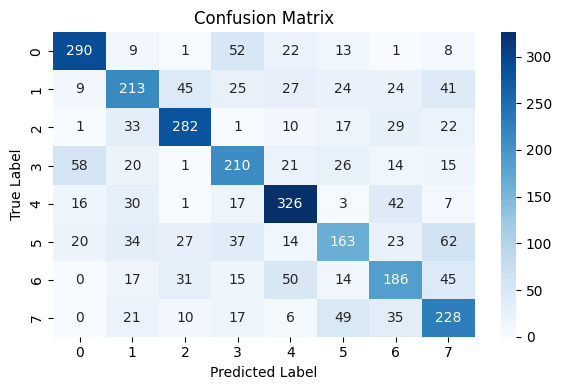

In [28]:
modelRS = ResNet_pre()
modelRS.load_state_dict(torch.load(os.path.join('RS_Final_Project_Weights')))

metrics(modelRS, history_RS_cnn, test_loader)

In [29]:
class ResNet_pre_add(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        for name, param in self.base_model.named_parameters():
            if "layer4" in name:   
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)  
        x = self.fc(x)           
        return x
        

modelRS_add = ResNet_pre_add().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRS_add.parameters(), lr=0.0001) 
EPOCHS = 10
resultsRS_add = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(modelRS_add, train_loader, optimizer, criterion)
    vl, va = evaluate(modelRS_add, test_loader, criterion)

    resultsRS_add.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(modelRS_add.state_dict(), 'RS_add_Final_Project_Weights')

# Convert to DataFrame for analysis
history_RS_add_cnn = pd.DataFrame(resultsRS_add)

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | train_loss=1.1103 val_loss=0.8195 train_acc=0.5911 val_acc=0.6990
Epoch 02 | train_loss=0.7228 val_loss=0.7643 train_acc=0.7381 val_acc=0.7176
Epoch 03 | train_loss=0.4535 val_loss=0.8207 train_acc=0.8413 val_acc=0.7150
Epoch 04 | train_loss=0.1958 val_loss=0.9880 train_acc=0.9415 val_acc=0.7032
Epoch 05 | train_loss=0.0711 val_loss=1.0505 train_acc=0.9815 val_acc=0.7107
Epoch 06 | train_loss=0.0369 val_loss=1.1503 train_acc=0.9916 val_acc=0.7196
Epoch 07 | train_loss=0.0253 val_loss=1.1864 train_acc=0.9952 val_acc=0.7176
Epoch 08 | train_loss=0.0133 val_loss=1.2737 train_acc=0.9976 val_acc=0.7046
Epoch 09 | train_loss=0.0131 val_loss=1.2809 train_acc=0.9972 val_acc=0.7215
Epoch 10 | train_loss=0.0162 val_loss=1.3851 train_acc=0.9955 val_acc=0.7065


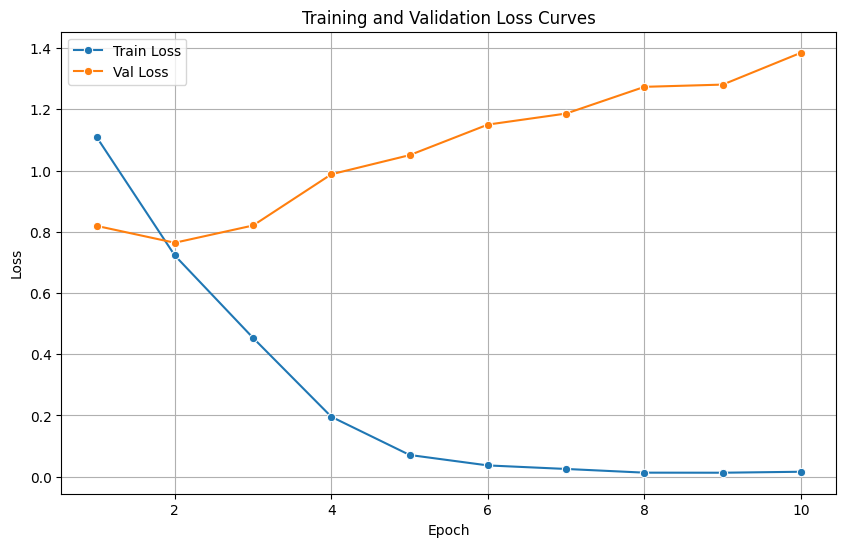

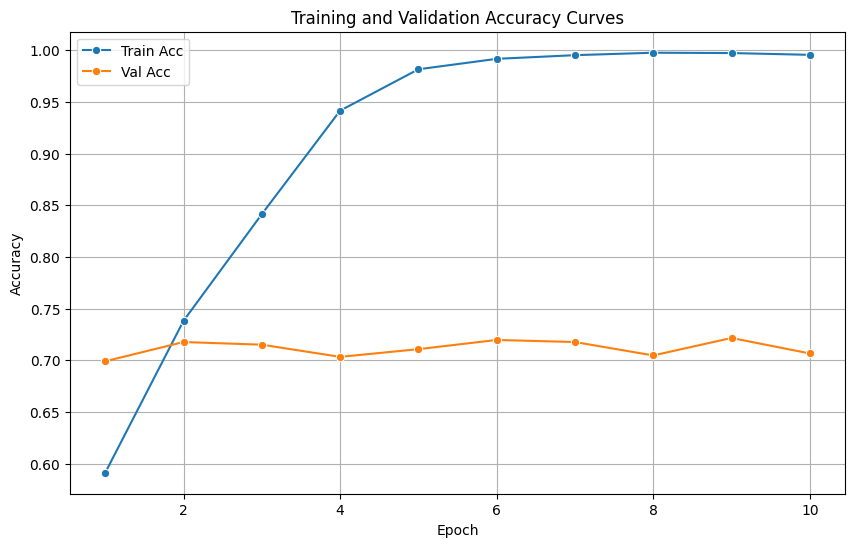

F1 Score: 0.7009


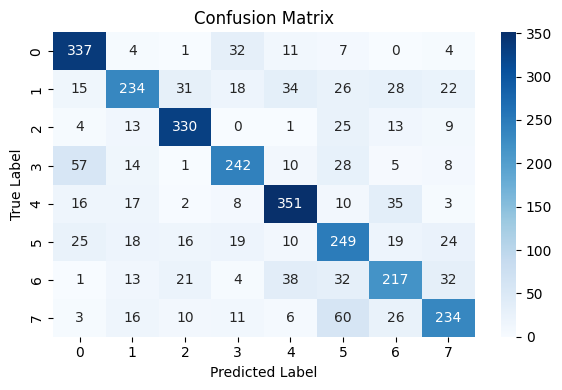

In [32]:
modelRS_add = ResNet_pre_add()
modelRS_add.load_state_dict(torch.load(os.path.join('RS_add_Final_Project_Weights')))

metrics(modelRS_add,history_RS_add_cnn, test_loader)

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        
        self.base_model = models.resnet50(pretrained=True)
        
        # freeze backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        
        # replace fc with a trainable classifier
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
modelRS50 = ResNet50().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRS50.parameters(), lr=0.0001) 
EPOCHS = 10
resultsRS50 = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(modelRS50, train_loader, optimizer, criterion)
    vl, va = evaluate(modelRS50, test_loader, criterion)

    resultsRS50.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(modelRS50.state_dict(), 'RS50_Final_Project_Weights')

# Convert to DataFrame for analysis
history_RS50_cnn = pd.DataFrame(resultsRS50)

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\monke/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:04<00:00, 24.4MB/s]


Epoch 01 | train_loss=1.6700 val_loss=1.4169 train_acc=0.4520 val_acc=0.5383
Epoch 02 | train_loss=1.3108 val_loss=1.2455 train_acc=0.5586 val_acc=0.5628
Epoch 03 | train_loss=1.1936 val_loss=1.1696 train_acc=0.5800 val_acc=0.5711
Epoch 04 | train_loss=1.1329 val_loss=1.1304 train_acc=0.5906 val_acc=0.5848
Epoch 05 | train_loss=1.1001 val_loss=1.1055 train_acc=0.5978 val_acc=0.5842
Epoch 06 | train_loss=1.0741 val_loss=1.0849 train_acc=0.6057 val_acc=0.5880
Epoch 07 | train_loss=1.0547 val_loss=1.0710 train_acc=0.6102 val_acc=0.5835
Epoch 08 | train_loss=1.0401 val_loss=1.0593 train_acc=0.6128 val_acc=0.5963
Epoch 09 | train_loss=1.0274 val_loss=1.0498 train_acc=0.6179 val_acc=0.5915
Epoch 10 | train_loss=1.0166 val_loss=1.0406 train_acc=0.6203 val_acc=0.5925


NameError: name 'pd' is not defined

C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\monke\anaconda3\envs\csc4505\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


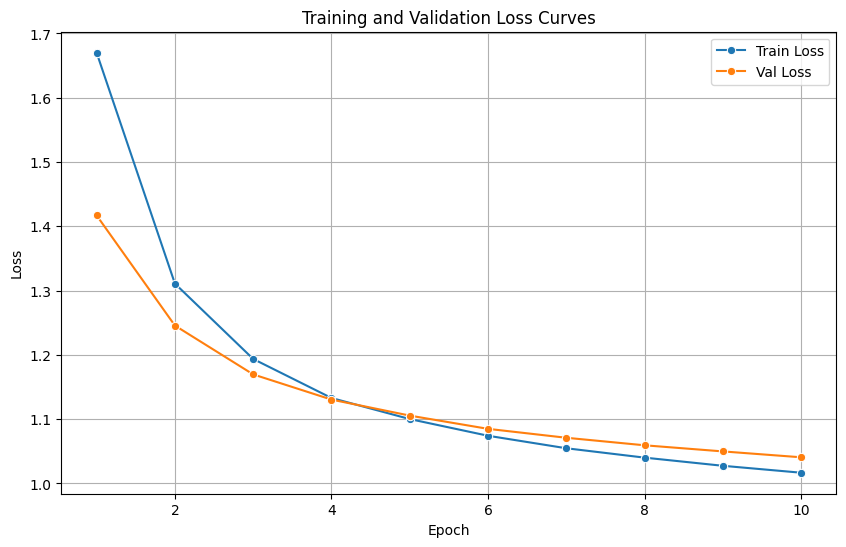

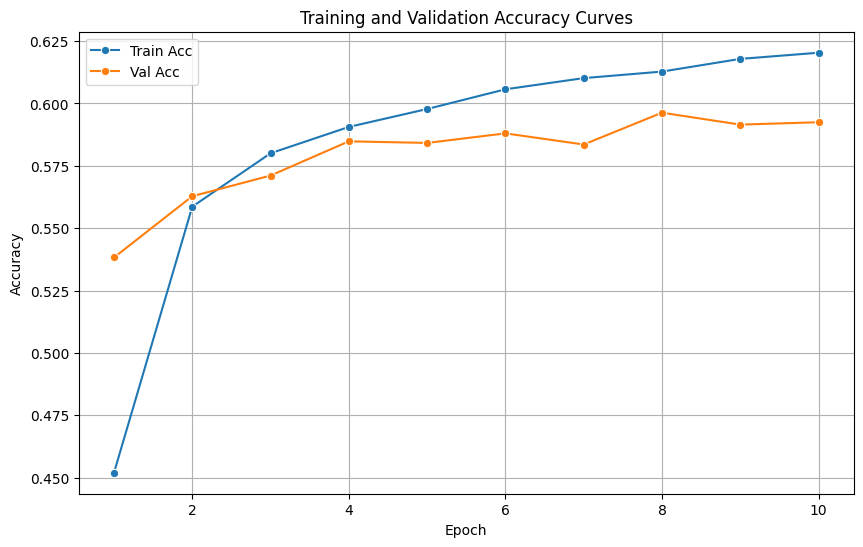

F1 Score: 0.6362


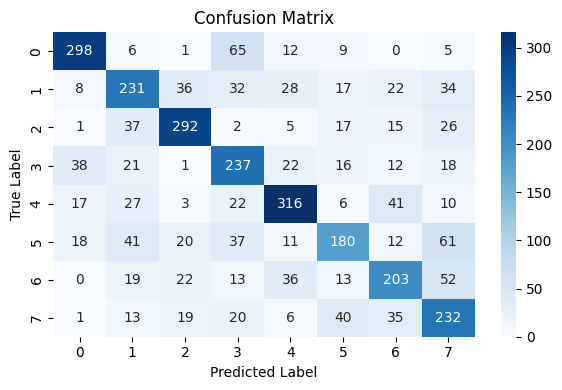

In [33]:
modelRS50 = ResNet50()
modelRS50.load_state_dict(torch.load(os.path.join('RS50_Final_Project_Weights')))

metrics(modelRS50, history_RS50_cnn, test_loader)

In [9]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

class ConvNext(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        # Load pretrained ConvNeXt-Tiny
        self.base_model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        in_features = self.base_model.classifier[2].in_features
        self.base_model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
ConvNext = ConvNext().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNext.parameters(), lr=0.0001) 
EPOCHS = 10
resultsConvNext = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(ConvNext, train_loader, optimizer, criterion)
    vl, va = evaluate(ConvNext, test_loader, criterion)

    resultsConvNext.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(ConvNext.state_dict(), 'ConvNext_Final_Project_Weights')

# Convert to DataFrame for analysis
history_ConvNext = pd.DataFrame(resultsConvNext)


Epoch 01 | train_loss=0.9270 val_loss=0.7302 train_acc=0.6523 val_acc=0.7102
Epoch 02 | train_loss=0.6055 val_loss=0.7047 train_acc=0.7724 val_acc=0.7288
Epoch 03 | train_loss=0.4101 val_loss=0.6622 train_acc=0.8545 val_acc=0.7540
Epoch 04 | train_loss=0.2389 val_loss=0.7536 train_acc=0.9205 val_acc=0.7465
Epoch 05 | train_loss=0.1211 val_loss=0.8322 train_acc=0.9629 val_acc=0.7389
Epoch 06 | train_loss=0.0708 val_loss=0.9338 train_acc=0.9795 val_acc=0.7412
Epoch 07 | train_loss=0.0620 val_loss=1.0165 train_acc=0.9807 val_acc=0.7416
Epoch 08 | train_loss=0.0480 val_loss=1.1103 train_acc=0.9861 val_acc=0.7346
Epoch 09 | train_loss=0.0449 val_loss=1.0293 train_acc=0.9861 val_acc=0.7444
Epoch 10 | train_loss=0.0408 val_loss=1.1795 train_acc=0.9876 val_acc=0.7319


NameError: name 'pd' is not defined

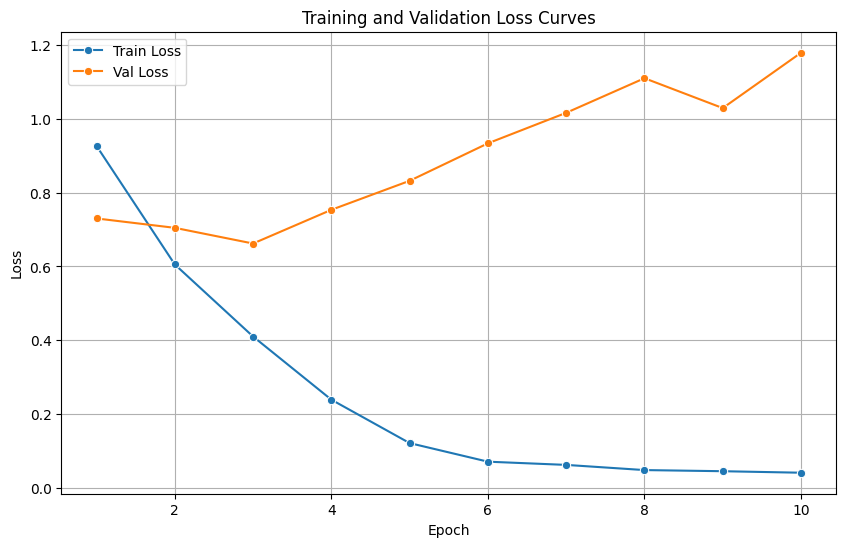

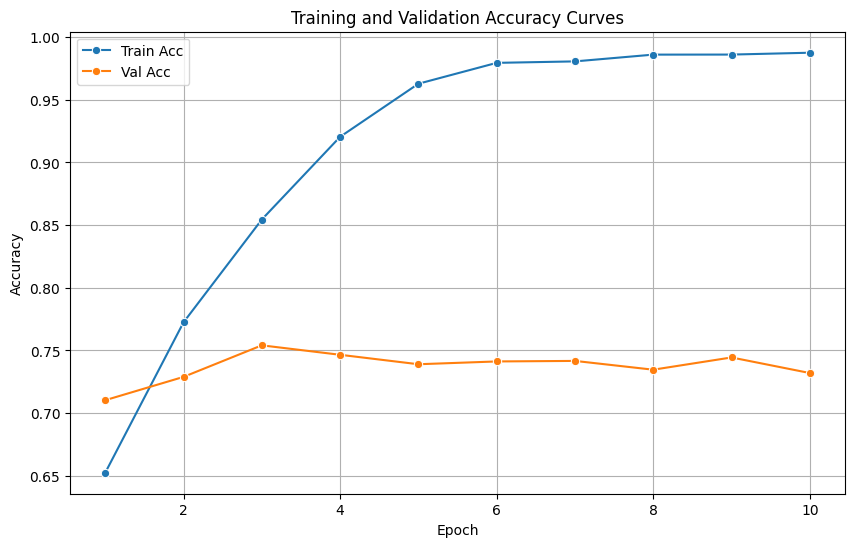

F1 Score: 0.7304


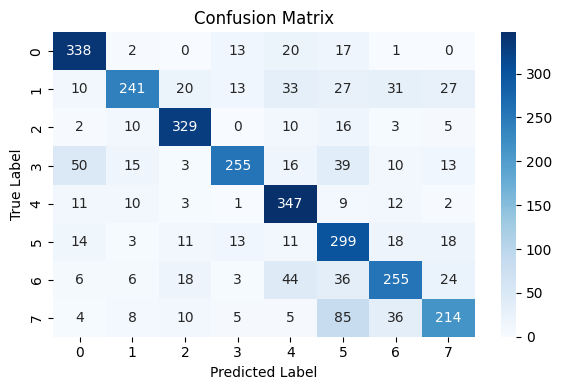

In [13]:
ConvNext.load_state_dict(torch.load(os.path.join('ConvNext_Final_Project_Weights')))

metrics(ConvNext, history_ConvNext, test_loader)

In [12]:
def evaluate_2(model, loader, criterion, device, scaler):
    model.eval()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)

            total_loss += loss.item()
            total_acc += accuracy(logits, y)
            n_batches += 1

    return total_loss / n_batches, total_acc / n_batches
def train_one_epoch_2(model, loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # Mixed precision
        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc += accuracy(logits.detach(), y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

In [3]:
import torch
print(torch.cuda.is_available())  # Should now return True
print(torch.cuda.get_device_name(0))  # Should print "NVIDIA GeForce RTX 4050"

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [13]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

class ConvNext2(nn.Module):
    def __init__(self, num_classes=8, freeze_backbone=True):
        super().__init__()
        self.base_model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        # Freeze backbone if desired
        if freeze_backbone:
            for param in self.base_model.features.parameters():
                param.requires_grad = False

        # Replace classifier
        in_features = self.base_model.classifier[2].in_features
        self.base_model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNext2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization

EPOCHS = 10
resultsConvNext2 = []

scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch_2(model, train_loader, optimizer, criterion, device=device, scaler=scaler)
    
    vl, va = evaluate_2(model, test_loader, criterion, device=device, scaler=scaler)

    resultsConvNext2.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")

    if epoch % 5 == 0:
        torch.save(model.state_dict(), 'ConvNext_Final_Project_Weights_2')

history_ConvNext2 = pd.DataFrame(resultsConvNext2)

C:\Users\monke\AppData\Local\Temp\ipykernel_207592\277654372.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train_loss=1.7291 val_loss=1.4720 train_acc=0.4092 val_acc=0.4998
Epoch 02 | train_loss=1.3701 val_loss=1.2786 train_acc=0.5353 val_acc=0.5367
Epoch 03 | train_loss=1.2302 val_loss=1.1899 train_acc=0.5629 val_acc=0.5561
Epoch 04 | train_loss=1.1595 val_loss=1.1391 train_acc=0.5774 val_acc=0.5749
Epoch 05 | train_loss=1.1098 val_loss=1.1051 train_acc=0.5926 val_acc=0.5800
Epoch 06 | train_loss=1.0783 val_loss=1.0815 train_acc=0.5996 val_acc=0.5864
Epoch 07 | train_loss=1.0522 val_loss=1.0627 train_acc=0.6080 val_acc=0.5938
Epoch 08 | train_loss=1.0343 val_loss=1.0464 train_acc=0.6126 val_acc=0.5931
Epoch 09 | train_loss=1.0204 val_loss=1.0342 train_acc=0.6201 val_acc=0.6008
Epoch 10 | train_loss=1.0064 val_loss=1.0234 train_acc=0.6239 val_acc=0.6027


In [21]:
torch.save(model.state_dict(), "../trial_weights/ConvNext_Final_Project_Weights_2.pth")

In [22]:
model = ConvNext2(num_classes=8, freeze_backbone=True)
model = model.to(device)
model.load_state_dict(
    torch.load("../trial_weights/ConvNext_Final_Project_Weights_2.pth", map_location=device)
)


C:\Users\monke\AppData\Local\Temp\ipykernel_207592\740818020.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../trial_weights/ConvNext_Final_Project_Weights_

<All keys matched successfully>

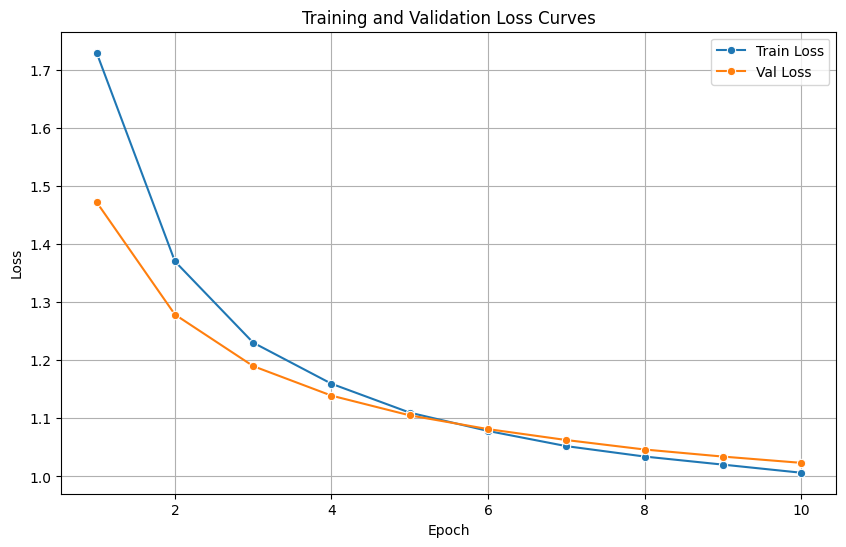

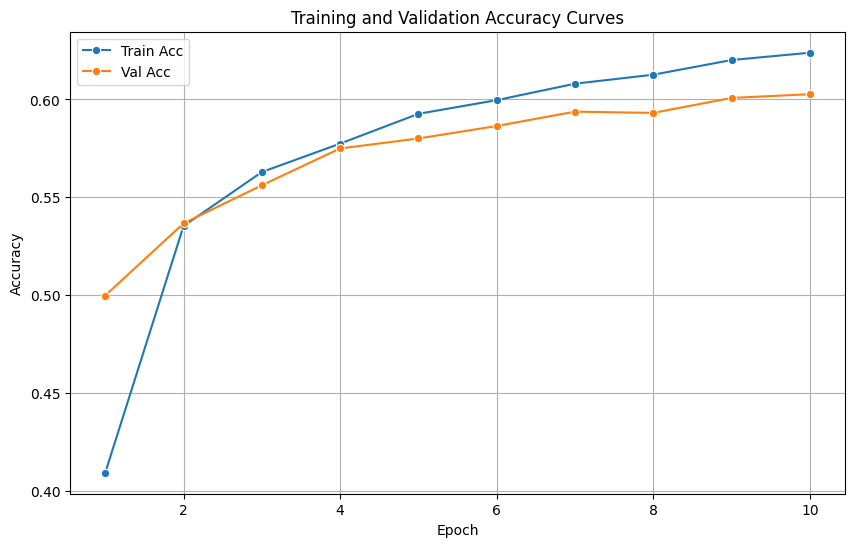

TypeError: Module.eval() missing 1 required positional argument: 'self'

In [17]:

metrics(ConvNext2, history_ConvNext2, test_loader)

F1 (macro): 0.6007496736978245
F1 (micro): 0.6028938906752411
F1 (weighted): 0.6001156760270077
Precision (macro): 0.6016496696184792
Recall (macro): 0.6043415382383909
F1 Score (Macro): 0.6007


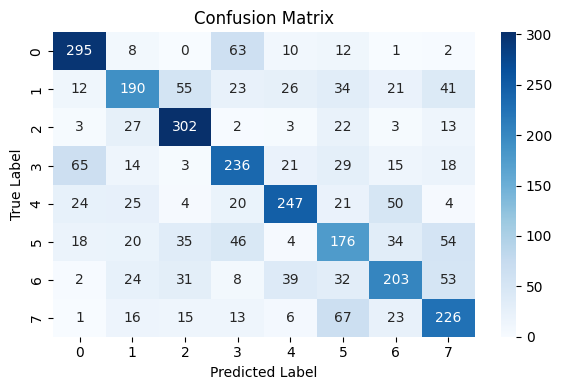

Confusion Matrix:
 [[295   8   0  63  10  12   1   2]
 [ 12 190  55  23  26  34  21  41]
 [  3  27 302   2   3  22   3  13]
 [ 65  14   3 236  21  29  15  18]
 [ 24  25   4  20 247  21  50   4]
 [ 18  20  35  46   4 176  34  54]
 [  2  24  31   8  39  32 203  53]
 [  1  16  15  13   6  67  23 226]]
ROC AUC (macro): 0.9216083427793085
ROC AUC (weighted): 0.9212803416117046
ROC AUC (macro): 0.9216083427793085
ROC AUC (weighted): 0.9212803416117046


In [23]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
def get_all_preds(model, loader, device="cuda"):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    return all_preds, all_probs, all_targets

preds, probs, targets = get_all_preds(model, test_loader, device)
print("F1 (macro):", f1_score(targets, preds, average="macro"))
print("F1 (micro):", f1_score(targets, preds, average="micro"))
print("F1 (weighted):", f1_score(targets, preds, average="weighted"))

print("Precision (macro):", precision_score(targets, preds, average="macro"))
print("Recall (macro):", recall_score(targets, preds, average="macro"))

cf_matrix = confusion_matrix(targets, preds)

f1_cnn = f1_score(targets, preds, average='macro')
print(f"F1 Score (Macro): {f1_cnn:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)


In [25]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

class ConvNext3(nn.Module):
    def __init__(self, num_classes=8, freeze_backbone=True):
        super().__init__()
        self.base_model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        # Freeze backbone if desired
        if freeze_backbone:
            for param in self.base_model.features.parameters():
                param.requires_grad = False
        
            for param in self.base_model.features[-1].parameters():
                param.requires_grad = True


        # Replace classifier
        in_features = self.base_model.classifier[2].in_features
        self.base_model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = ConvNext3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-5)  # L2 regularization

EPOCHS = 10
resultsConvNext3 = []

scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch_2(model2, train_loader, optimizer, criterion, device=device, scaler=scaler)
    
    vl, va = evaluate_2(model2, test_loader, criterion, device=device, scaler=scaler)

    resultsConvNext3.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")

    if epoch % 5 == 0:
        torch.save(model2.state_dict(), "../trial_weights/ConvNext_Final_Project_Weights_3.pth")

history_ConvNext3 = pd.DataFrame(resultsConvNext3)

C:\Users\monke\AppData\Local\Temp\ipykernel_207592\3985611233.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train_loss=1.1192 val_loss=0.9243 train_acc=0.5811 val_acc=0.6403
Epoch 02 | train_loss=0.8353 val_loss=0.8422 train_acc=0.6869 val_acc=0.6763
Epoch 03 | train_loss=0.7001 val_loss=0.8118 train_acc=0.7426 val_acc=0.6852
Epoch 04 | train_loss=0.5638 val_loss=0.8183 train_acc=0.8000 val_acc=0.6965
Epoch 05 | train_loss=0.4401 val_loss=0.8589 train_acc=0.8489 val_acc=0.6911
Epoch 06 | train_loss=0.3332 val_loss=0.8970 train_acc=0.8874 val_acc=0.6958
Epoch 07 | train_loss=0.2583 val_loss=0.9775 train_acc=0.9154 val_acc=0.6888
Epoch 08 | train_loss=0.2138 val_loss=1.0744 train_acc=0.9302 val_acc=0.6865
Epoch 09 | train_loss=0.1740 val_loss=1.0934 train_acc=0.9434 val_acc=0.6913
Epoch 10 | train_loss=0.1537 val_loss=1.1355 train_acc=0.9497 val_acc=0.6891


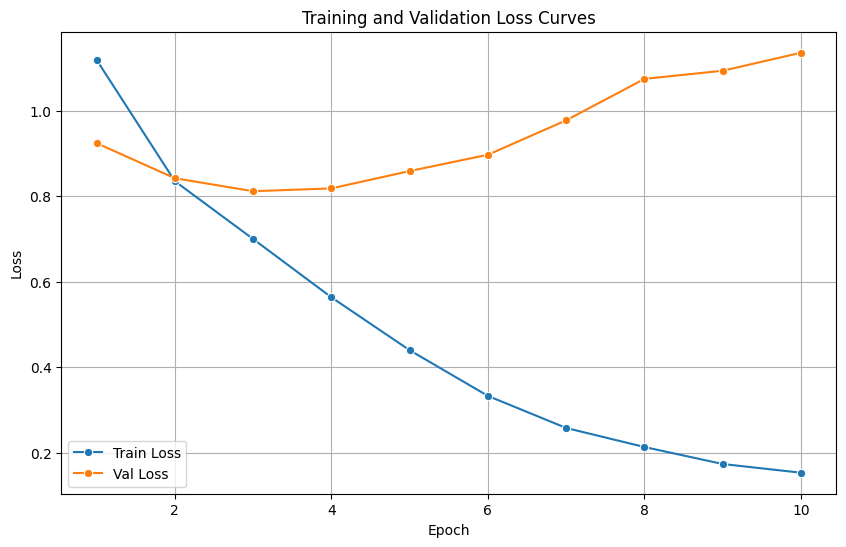

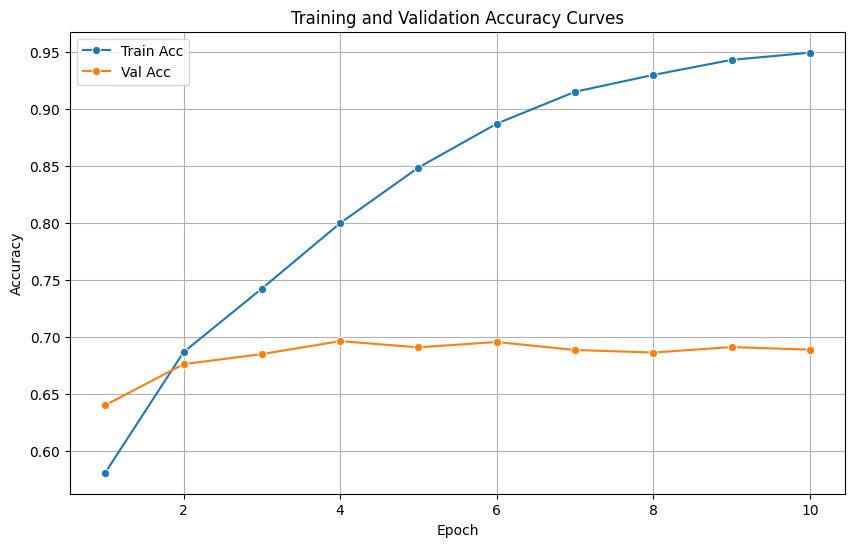

F1 Score: 0.6907


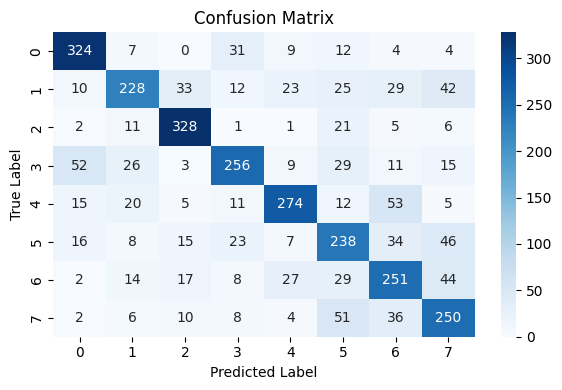

In [27]:
metrics(model2, history_ConvNext3, test_loader)

F1 (macro): 0.6906865540543229
F1 (micro): 0.6909967845659164
F1 (weighted): 0.690240769261985
Precision (macro): 0.6941088727613112
Recall (macro): 0.6923802919731108
F1 Score (Macro): 0.6907


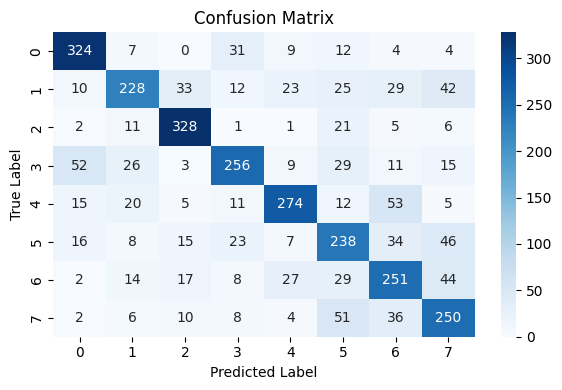

Confusion Matrix:
 [[295   8   0  63  10  12   1   2]
 [ 12 190  55  23  26  34  21  41]
 [  3  27 302   2   3  22   3  13]
 [ 65  14   3 236  21  29  15  18]
 [ 24  25   4  20 247  21  50   4]
 [ 18  20  35  46   4 176  34  54]
 [  2  24  31   8  39  32 203  53]
 [  1  16  15  13   6  67  23 226]]
ROC AUC (macro): 0.9482340277028778
ROC AUC (weighted): 0.9480282799680686
ROC AUC (macro): 0.9482340277028778
ROC AUC (weighted): 0.9480282799680686


In [26]:

def get_all_preds(model, loader, device="cuda"):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    return all_preds, all_probs, all_targets

preds, probs, targets = get_all_preds(model2, test_loader, device)
print("F1 (macro):", f1_score(targets, preds, average="macro"))
print("F1 (micro):", f1_score(targets, preds, average="micro"))
print("F1 (weighted):", f1_score(targets, preds, average="weighted"))

print("Precision (macro):", precision_score(targets, preds, average="macro"))
print("Recall (macro):", recall_score(targets, preds, average="macro"))

cf_matrix = confusion_matrix(targets, preds)

f1_cnn = f1_score(targets, preds, average='macro')
print(f"F1 Score (Macro): {f1_cnn:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)


In [29]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

class ConvNext4(nn.Module):
    def __init__(self, num_classes=8, freeze_backbone=True):
        super().__init__()
        self.base_model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        # Freeze backbone if desired
        if freeze_backbone:
            for param in self.base_model.features.parameters():
                param.requires_grad = False
        
            for param in self.base_model.features[-1].parameters():
                param.requires_grad = True


        # Replace classifier
        in_features = self.base_model.classifier[2].in_features
        self.base_model.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ConvNext4().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization

EPOCHS = 10
resultsConvNext4 = []

scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch_2(model3, train_loader, optimizer, criterion, device=device, scaler=scaler)
    
    vl, va = evaluate_2(model3, test_loader, criterion, device=device, scaler=scaler)

    resultsConvNext4.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")

    if epoch % 5 == 0:
        torch.save(model3.state_dict(), "../trial_weights/ConvNext_Final_Project_Weights_4.pth")

history_ConvNext4 = pd.DataFrame(resultsConvNext4)

C:\Users\monke\AppData\Local\Temp\ipykernel_207592\3749807422.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\monke\AppData\Local\Temp\ipykernel_207592\1423672559.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train_loss=1.1170 val_loss=0.9286 train_acc=0.5863 val_acc=0.6473
Epoch 02 | train_loss=0.8370 val_loss=0.8516 train_acc=0.6887 val_acc=0.6779
Epoch 03 | train_loss=0.7091 val_loss=0.8255 train_acc=0.7388 val_acc=0.6853
Epoch 04 | train_loss=0.5823 val_loss=0.8408 train_acc=0.7900 val_acc=0.6918
Epoch 05 | train_loss=0.4615 val_loss=0.8639 train_acc=0.8366 val_acc=0.6973
Epoch 06 | train_loss=0.3474 val_loss=0.9321 train_acc=0.8829 val_acc=0.6941
Epoch 07 | train_loss=0.2647 val_loss=0.9707 train_acc=0.9118 val_acc=0.6915
Epoch 08 | train_loss=0.2136 val_loss=1.0614 train_acc=0.9294 val_acc=0.6962
Epoch 09 | train_loss=0.1764 val_loss=1.1187 train_acc=0.9434 val_acc=0.6898
Epoch 10 | train_loss=0.1561 val_loss=1.1244 train_acc=0.9496 val_acc=0.6922


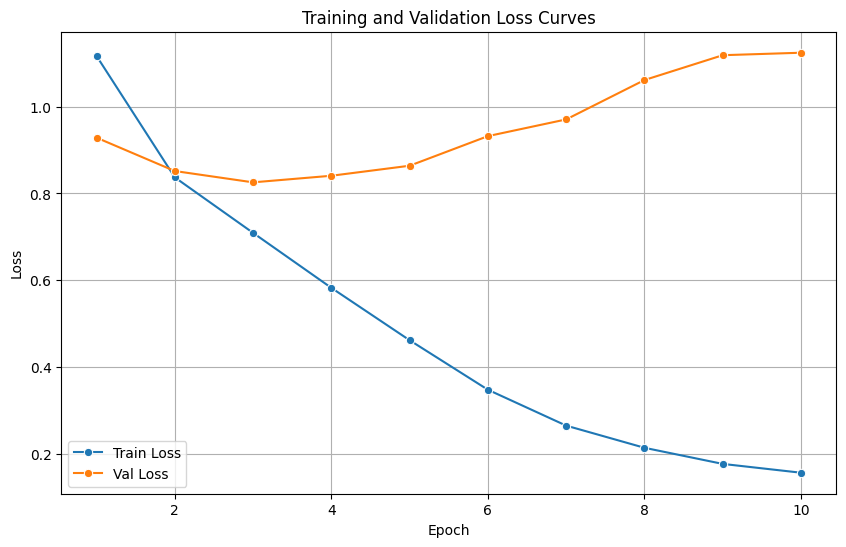

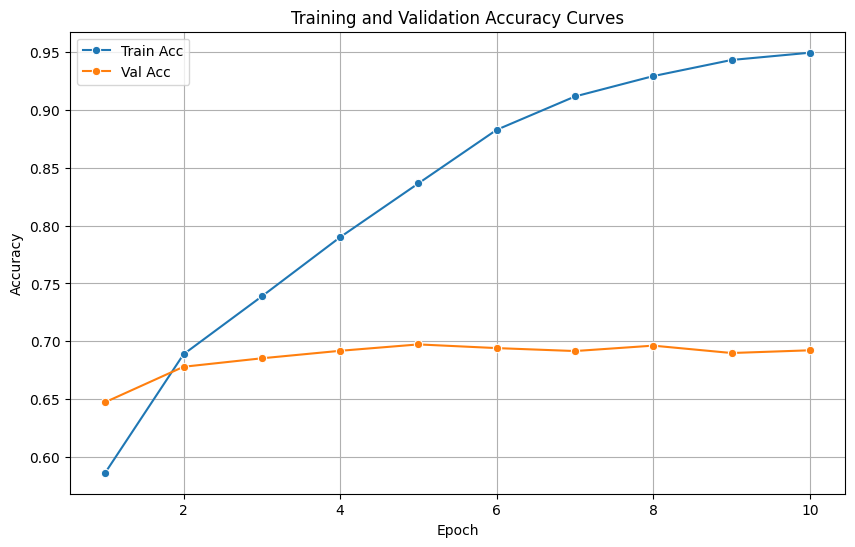

F1 Score: 0.6911


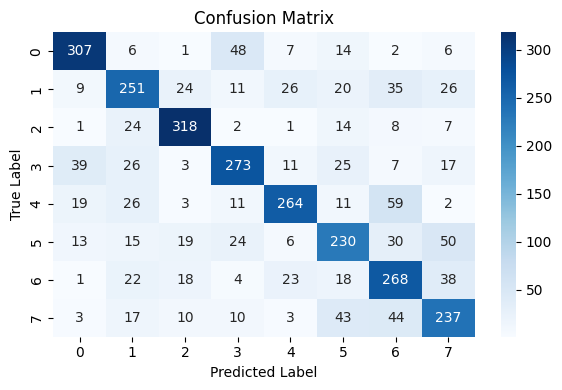

In [32]:
metrics(model3, history_ConvNext4, test_loader)

F1 (macro): 0.6911410695445228
F1 (micro): 0.6906752411575563
F1 (weighted): 0.6908601372424285
Precision (macro): 0.6931879287187627
Recall (macro): 0.6913077583565632
F1 Score (Macro): 0.6911


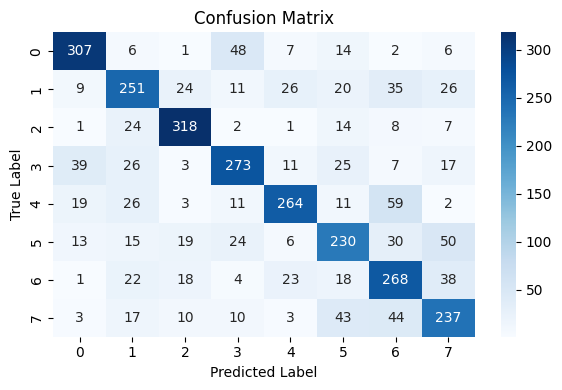

Confusion Matrix:
 [[295   8   0  63  10  12   1   2]
 [ 12 190  55  23  26  34  21  41]
 [  3  27 302   2   3  22   3  13]
 [ 65  14   3 236  21  29  15  18]
 [ 24  25   4  20 247  21  50   4]
 [ 18  20  35  46   4 176  34  54]
 [  2  24  31   8  39  32 203  53]
 [  1  16  15  13   6  67  23 226]]
ROC AUC (macro): 0.9487499094108325
ROC AUC (weighted): 0.9485802374571446
ROC AUC (macro): 0.9487499094108325
ROC AUC (weighted): 0.9485802374571446


In [31]:

def get_all_preds(model, loader, device="cuda"):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    return all_preds, all_probs, all_targets

preds, probs, targets = get_all_preds(model3, test_loader, device)
print("F1 (macro):", f1_score(targets, preds, average="macro"))
print("F1 (micro):", f1_score(targets, preds, average="micro"))
print("F1 (weighted):", f1_score(targets, preds, average="weighted"))

print("Precision (macro):", precision_score(targets, preds, average="macro"))
print("Recall (macro):", recall_score(targets, preds, average="macro"))

cf_matrix = confusion_matrix(targets, preds)

f1_cnn = f1_score(targets, preds, average='macro')
print(f"F1 Score (Macro): {f1_cnn:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)
# One-vs-rest AUC
auc_macro = roc_auc_score(targets, probs, multi_class="ovr", average="macro")
auc_weighted = roc_auc_score(targets, probs, multi_class="ovr", average="weighted")

print("ROC AUC (macro):", auc_macro)
print("ROC AUC (weighted):", auc_weighted)


